In [1]:
import pandas as pd

professors_df = pd.read_csv('RateMyProfAnalysis/UMassReviews/professors_df_clean.csv')
reviews_df = pd.read_csv('RateMyProfAnalysis/UMassReviews/reviews_df_clean.csv')

print(professors_df.head())
print(reviews_df.head())



        id                name   department  total_reviews_count  \
0   203815       John Bickford   Psychology                  449   
1    77120     Randall Phillis      Biology                  388   
2  1621419       Laura Francis      Biology                  370   
3   192549  Joanna Jeneralczuk  Mathematics                  323   
4  1617241      Chris McDaniel    Chemistry                  298   

   average_quality_rating  average_difficulty_rating  \
0                4.077951                   2.031180   
1                3.920103                   3.298969   
2                2.659459                   4.000000   
3                3.780186                   3.142415   
4                2.104027                   4.342282   

                                      classes_taught  \
0  ['PSYCH100', 'PSYCH370', '100', 'PSCYH100', 'P...   
1  ['BIO151', '151', '100', 'BIOLOGY151', 'BIO484...   
2  ['161H', 'BIO151', '285', 'BIO285', '151', 'BI...   
3  ['STAT240', 'STAT501', 'STA

In [2]:
from textblob import TextBlob

#lets do a little example with the first review
review = reviews_df.iloc[0]
print(review['comment'])

#lets get the 'TextBlob' of the review
wiki = TextBlob(review['comment'])
print(wiki.noun_phrases)

#lets get the sentiment of the review
sentiment = wiki.sentiment
print(sentiment) 
#this is a tuple with the polarity and subjectivity
#polarity is a float between -1 and 1, with 1 indicating a very positive sentiment and -1 indicating a very negative sentiment
#subjectivity is a float between 0 and 1, with 0 indicating a very objective sentiment and 1 indicating a very subjective sentiment

reviews_df['sentiment'] = reviews_df['comment'].apply(lambda x: TextBlob(x).sentiment)
print(reviews_df['sentiment'])

Bickford was easily my favorite teacher. His lectures were fun to attend even though they weren't mandatory. You have to complete 6 reaction papers in class, there are 4 midterms (no final) and you get a cheat sheet for all of them- pretty easy all multiple choice. The textbook assignments were quick, and helped to learn the material! 
['bickford', 'favorite teacher', 'reaction papers', 'cheat sheet', 'multiple choice', 'textbook assignments']
Sentiment(polarity=0.25, subjectivity=0.6166666666666667)
0                         (0.25, 0.6166666666666667)
1          (0.31888888888888894, 0.5788888888888889)
2                                     (0.2225, 0.71)
3           (0.2743055555555556, 0.3861111111111111)
4           (0.3458333333333333, 0.6291666666666667)
                            ...                     
45169      (0.32916666666666666, 0.8333333333333334)
45170                                    (0.32, 0.4)
45171     (-0.2733072916666667, 0.47916666666666663)
45172    (-0.0099

In [3]:
import json
# First, let's see what the string actually looks like
print('Raw string:', professors_df['class_map'].iloc[0])

def clean_and_parse_json(x):
    if not isinstance(x, str):
        return x
    try:
        # First attempt: direct JSON parse
        return json.loads(x)
    except json.JSONDecodeError:
        try:
            # Second attempt: Replace single quotes with double quotes
            x = x.replace("'", '"')
            return json.loads(x)
        except json.JSONDecodeError:
            try:
                # Third attempt: Use ast.literal_eval (safer than eval)
                import ast
                return ast.literal_eval(x)
            except:
                print(f"Failed to parse: {x[:100]}...")  # Print first 100 chars
                return {}  # Return empty dict if all parsing attempts fail

# Apply the cleaning and parsing
professors_df['class_map'] = professors_df['class_map'].apply(clean_and_parse_json)

# Verify the conversion worked
print("\nAfter conversion:", type(professors_df['class_map'].iloc[0]))
print("Sample of converted data:", dict(list(professors_df['class_map'].iloc[0].items())[:2]))

# Now proceed with your sentiment analysis
sentiments = {}

for index, professor in professors_df.iterrows():
    professor_id = professor['id']
    sentiments[professor_id] = {}  # Initialize the inner dictionary
    
    class_map = professor['class_map']
    if isinstance(class_map, dict):  # Verify we have a valid dictionary
        for key, value in class_map.items():
            teacher_reviews = reviews_df[reviews_df['tid'] == professor_id]
            class_reviews = teacher_reviews[teacher_reviews['class_identifiers'].apply(lambda x: key in x)]
            if not class_reviews.empty:
                sentiments[professor_id][key] = class_reviews['sentiment'].apply(lambda x: x.polarity).mean()





Raw string: {"100": {"prefix": "PSYCH", "suffix": "", "labels": ["PSYCH100", "100", "PSCYH100", "PYSCH100", "PSY100", "PHSYC100", "PSYC100", "PSYCHOLOGY100", "PSYCTAP100", "PSYCH100360", "PSYCH100370"]}, "370": {"prefix": "PSYCH", "suffix": "", "labels": ["PSYCH370", "PSY370", "PSYC370", "PYSCH370", "370", "PSYCHOLOGY370", "PSYCH100370", "PSYCH360370"]}, "360": {"prefix": "PSYCH", "suffix": "", "labels": ["PSY360", "PSYCH360", "PSYCH100360", "PSYCH360370"]}, "391": {"prefix": "PSYCH", "suffix": "ZZ", "labels": ["PSYCH391", "PSYCH391ZZ"]}, "380": {"prefix": "PSYCH", "suffix": "", "labels": ["PSYCH380"]}, "270": {"prefix": "PSYCH", "suffix": "", "labels": ["PSYCH270"]}, "101": {"prefix": "PSYCH", "suffix": "", "labels": ["PSYCH101"]}, "355": {"prefix": "PSYCH", "suffix": "", "labels": ["PSYCH355"]}, "240": {"prefix": "PSYCH", "suffix": "", "labels": ["PSYCH240"]}, "misc": {"prefix": "", "suffix": "", "labels": ["PERSONALITY", "INTROTOPSYCH", "SOCIALPSYCH", "PSYCHINTR", "SOCPSYCH", "PERS1

In [4]:
highest_sentiment_professor_id = max(sentiments, key=lambda x: sum(sentiments[x].values()) / len(sentiments[x]))
lowest_sentiment_professor_id = min(sentiments, key=lambda x: sum(sentiments[x].values()) / len(sentiments[x]))

highest_sentiment_professor = professors_df.loc[professors_df['id'] == highest_sentiment_professor_id]
lowest_sentiment_professor = professors_df.loc[professors_df['id'] == lowest_sentiment_professor_id]

print("Professor with the highest overall sentiment:")
print(highest_sentiment_professor)
print("Sentiment by class:")
print(sentiments[highest_sentiment_professor_id])
print("5 random reviews:")
print(reviews_df[reviews_df['tid'] == highest_sentiment_professor_id].sample(5))

print("\nProfessor with the lowest overall sentiment:")
print(lowest_sentiment_professor)
print("Sentiment by class:")
print(sentiments[lowest_sentiment_professor_id])
print("5 random reviews:")
print(reviews_df[reviews_df['tid'] == lowest_sentiment_professor_id].sample(5))


Professor with the highest overall sentiment:
          id              name  department  total_reviews_count  \
812  1416553  Stella Xanthakos  Management                   21   

     average_quality_rating  average_difficulty_rating  \
812                4.809524                   1.952381   

                                        classes_taught  \
812  ['MGMT260', 'MAN260', 'LAW260', 'MANAGEMENT260...   

                                             class_map  
812  {'260': {'prefix': 'MGMT', 'suffix': '', 'labe...  
Sentiment by class:
{'260': np.float64(0.32603586781935), 'misc': np.float64(1.0)}
5 random reviews:
               class                                            comment  \
41732        MGMT260  Stella is fantastic and hands down my favorite...   
41739         LAW260  Stella is a quality teacher. The material is n...   
41735         MAN260  Stella is a great teacher and a very lenient g...   
41725  MANAGEMENT260  Stella is really inspiring and always shares s..

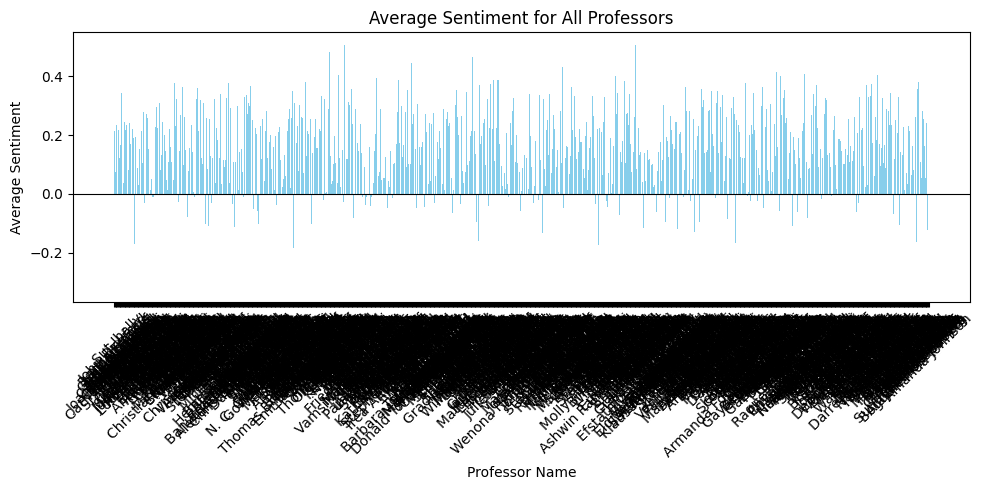


Sentiment over time for Professor John Bickford (ID 203815):
Date: 2003-10-27, Average Sentiment: 0.5328125, Running Average: 0.5328125
Date: 2003-11-22, Average Sentiment: 0.14805555555555555, Running Average: 0.34043402777777776
Date: 2004-04-19, Average Sentiment: 0.25, Running Average: 0.31028935185185186
Date: 2004-04-21, Average Sentiment: 0.315, Running Average: 0.31146701388888887
Date: 2004-04-26, Average Sentiment: 0.26416666666666666, Running Average: 0.3020069444444444
Date: 2004-04-27, Average Sentiment: -0.375, Running Average: 0.1891724537037037
Date: 2004-04-28, Average Sentiment: -0.03194444444444444, Running Average: 0.15758432539682538
Date: 2004-04-30, Average Sentiment: -0.12222222222222222, Running Average: 0.12260850694444442
Date: 2004-05-12, Average Sentiment: 0.5, Running Average: 0.16454089506172836
Date: 2004-05-21, Average Sentiment: 0.038666666666666696, Running Average: 0.1519534722222222
Date: 2004-07-02, Average Sentiment: 0.23333333333333334, Running 

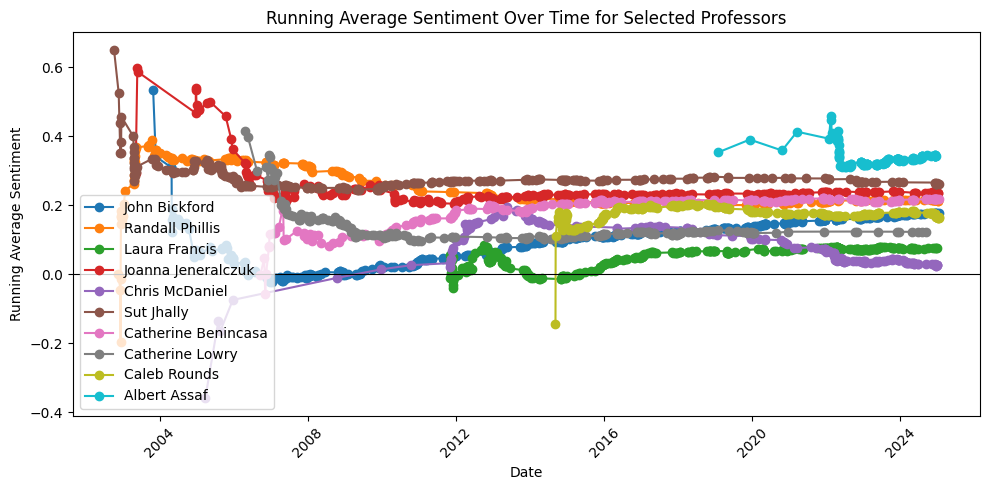

In [12]:
# Analyze sentiment based on time using year, month, and day fields
time_sentiments = {}

# Assuming 'reviews_df' has 'year', 'month', and 'day' columns for the review date
for index, professor in professors_df.iterrows():
    professor_id = professor['id']
    time_sentiments[professor_id] = {}  # Initialize the inner dictionary for time-based sentiment
    
    teacher_reviews = reviews_df[reviews_df['tid'] == professor_id].copy()  # Create a copy to avoid SettingWithCopyWarning
    
    # Create a 'date' column from year, month, and day
    teacher_reviews.loc[:,'date'] = pd.to_datetime(teacher_reviews[['year', 'month', 'day']])
    
    # Group reviews by date and calculate average sentiment
    daily_sentiment = teacher_reviews.groupby('date')['sentiment'].apply(lambda x: x.apply(lambda y: y.polarity).mean())
    
    # Store the daily sentiment in the time_sentiments dictionary
    time_sentiments[professor_id] = daily_sentiment.to_dict()

import matplotlib.pyplot as plt

# Calculate average sentiment for all professors
all_professors_sentiment = {}
for professor_id, daily_sent in time_sentiments.items():
    if daily_sent:  # Only calculate if there are sentiments
        all_professors_sentiment[professor_id] = sum(daily_sent.values()) / len(daily_sent)

# Plotting the average sentiment for all professors
plt.figure(figsize=(10, 5))
plt.bar(professors_df[professors_df['id'].isin(all_professors_sentiment.keys())]['name'], all_professors_sentiment.values(), color='skyblue', bottom=0)
plt.xlabel('Professor Name')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment for All Professors')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
plt.tight_layout()
plt.show()

def plot_running_average_sentiment(professor_ids, time_sentiments, professors_df):
    running_average_sentiments = {}  # Dictionary to keep track of running averages
    running_average_data = {}  # Dictionary to store data for plotting

    for professor_id in professor_ids:
        if time_sentiments[professor_id]:  # Only process if there are sentiments
            professor_name = professors_df.loc[professors_df['id'] == professor_id, 'name'].values[0]
            print(f"\nSentiment over time for Professor {professor_name} (ID {professor_id}):")
            
            cumulative_sentiment = 0
            count = 0
            dates = []
            running_averages = []
            
            for date, sentiment in sorted(time_sentiments[professor_id].items()):
                cumulative_sentiment += sentiment
                count += 1
                running_average = cumulative_sentiment / count
                print(f"Date: {date.date()}, Average Sentiment: {sentiment}, Running Average: {running_average}")
                dates.append(date.date())
                running_averages.append(running_average)
                running_average_sentiments[professor_id] = running_average  # Update running average for the professor
            
            # Store data for plotting
            running_average_data[professor_name] = (dates, running_averages)

    # Plotting the running averages for each sampled professor
    plt.figure(figsize=(10, 5))
    for professor_name, (dates, running_averages) in running_average_data.items():
        plt.plot(dates, running_averages, marker='o', label=professor_name)

    plt.xlabel('Date')
    plt.ylabel('Running Average Sentiment')
    plt.title('Running Average Sentiment Over Time for Selected Professors')
    plt.xticks(rotation=45)
    plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_running_average_sentiment(professors_df['id'][0:10], time_sentiments, professors_df)





Sentiment over time for Professor Mark Wilson (ID 2936075):
Date: 2023-10-15, Average Sentiment: 0.15000000000000002, Running Average: 0.15000000000000002
Date: 2023-10-20, Average Sentiment: -0.04062500000000001, Running Average: 0.05468750000000001
Date: 2023-10-23, Average Sentiment: -0.1611111111111111, Running Average: -0.01724537037037036
Date: 2023-10-31, Average Sentiment: -0.008333333333333326, Running Average: -0.015017361111111101
Date: 2023-11-10, Average Sentiment: -0.16467126623376627, Running Average: -0.04494814213564213
Date: 2023-11-12, Average Sentiment: -0.028571428571428564, Running Average: -0.042218689874939874
Date: 2023-11-13, Average Sentiment: -0.25, Running Average: -0.07190173417851989
Date: 2023-11-14, Average Sentiment: 0.495, Running Average: -0.0010390174062049062
Date: 2023-11-15, Average Sentiment: -0.09222222222222223, Running Average: -0.011170484607984608
Date: 2023-11-16, Average Sentiment: 0.034112914862914866, Running Average: -0.00664214466089

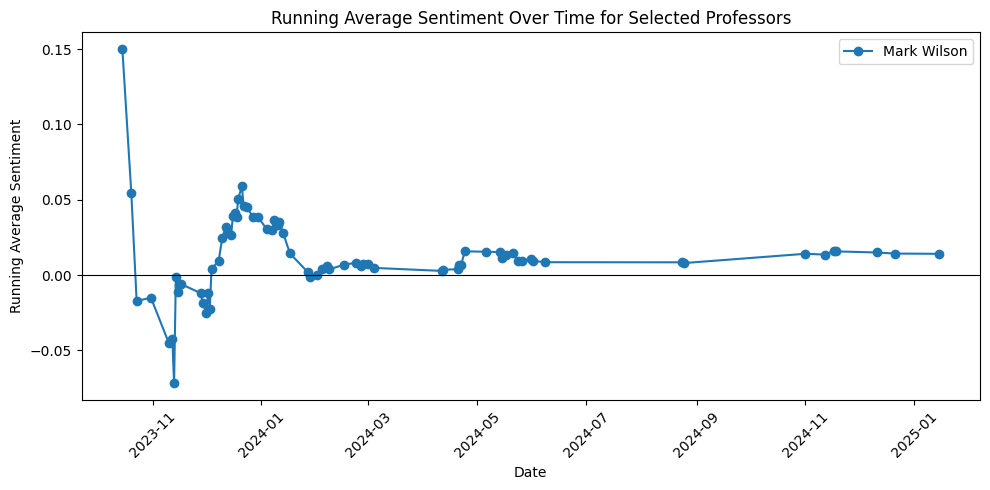

In [14]:
plot_running_average_sentiment([2936075], time_sentiments, professors_df)

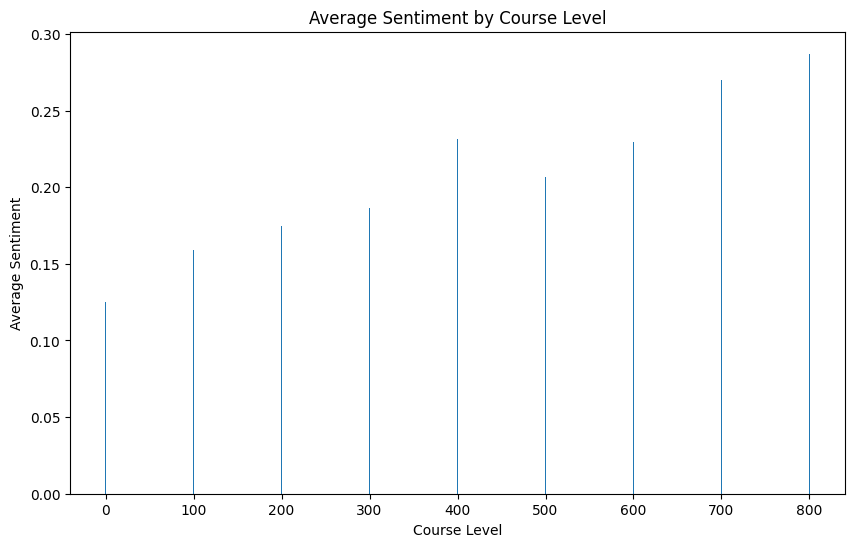

In [18]:
from collections import defaultdict  # Import defaultdict
import numpy as np

# Compare sentiment across different course levels
def analyze_course_levels(reviews_df, sentiments):
    course_level_sentiments = defaultdict(list)
    
    for professor_id, class_sentiments in sentiments.items():
        for class_num, sentiment in class_sentiments.items():
            if class_num.isdigit():
                level = int(class_num[0]) * 100  # e.g., 100, 200, 300-level courses
                course_level_sentiments[level].append(sentiment)
    
    # Plot average sentiment by course level
    levels = sorted(course_level_sentiments.keys())
    avg_sentiments = [np.mean(course_level_sentiments[level]) for level in levels]
    
    plt.figure(figsize=(10, 6))
    plt.bar(levels, avg_sentiments)
    plt.title('Average Sentiment by Course Level')
    plt.xlabel('Course Level')
    plt.ylabel('Average Sentiment')
    plt.show()

analyze_course_levels(reviews_df, sentiments)

C:\Users\16073\AppData\Local\Temp\ipykernel_22424\2173039808.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dept_data, labels=dept_sentiments.keys())


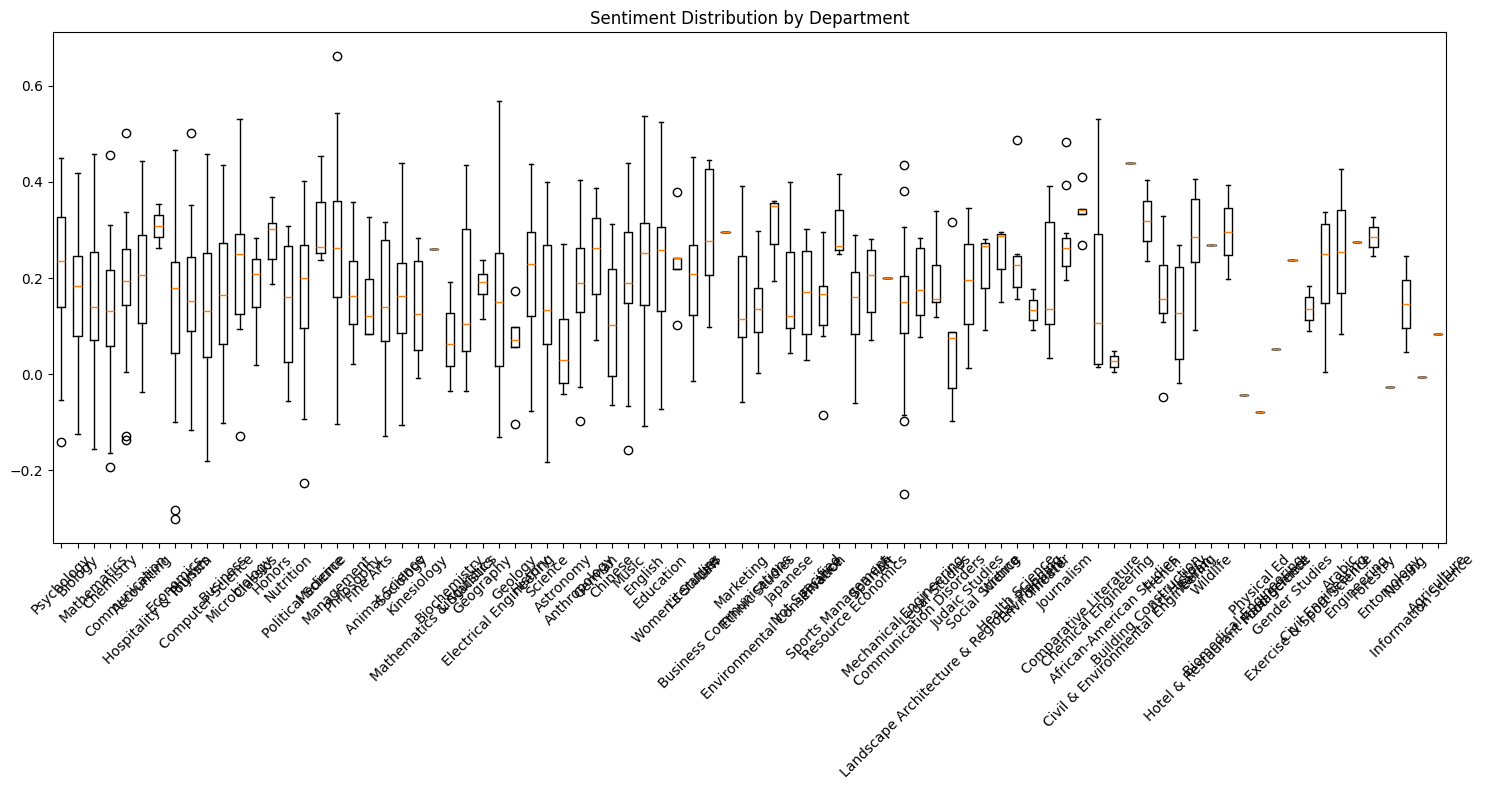

In [19]:
# Compare sentiments across departments
def analyze_department_sentiments(professors_df, sentiments):
    dept_sentiments = defaultdict(list)
    
    for professor_id, class_sentiments in sentiments.items():
        dept = professors_df.loc[professors_df['id'] == professor_id, 'department'].iloc[0]
        avg_sentiment = np.mean(list(class_sentiments.values()))
        dept_sentiments[dept].append(avg_sentiment)
    
    # Plot box plots for each department
    plt.figure(figsize=(15, 8))
    dept_data = [dept_sentiments[dept] for dept in dept_sentiments]
    plt.boxplot(dept_data, labels=dept_sentiments.keys())
    plt.xticks(rotation=45)
    plt.title('Sentiment Distribution by Department')
    plt.tight_layout()
    plt.show()

analyze_department_sentiments(professors_df, sentiments)


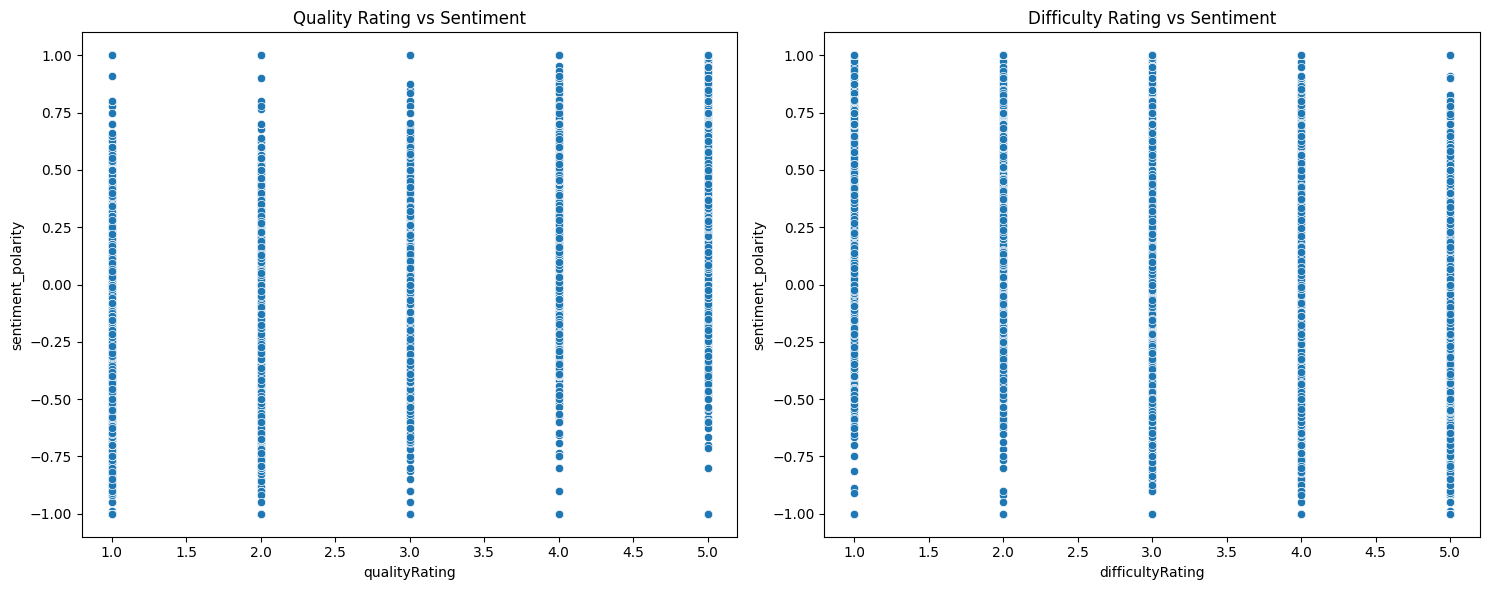


Correlations:
                     sentiment_polarity  qualityRating  difficultyRating
sentiment_polarity            1.000000       0.580495         -0.315896
qualityRating                 0.580495       1.000000         -0.454724
difficultyRating             -0.315896      -0.454724          1.000000


In [21]:
import seaborn as sns
# Analyze relationship between sentiment and ratings
def analyze_sentiment_rating_correlation(reviews_df):
    reviews_df['sentiment_polarity'] = reviews_df['sentiment'].apply(lambda x: x.polarity)
    
    # Create correlation plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Quality Rating vs Sentiment
    sns.scatterplot(data=reviews_df, x='qualityRating', y='sentiment_polarity', ax=axes[0])
    axes[0].set_title('Quality Rating vs Sentiment')
    
    # Difficulty Rating vs Sentiment
    sns.scatterplot(data=reviews_df, x='difficultyRating', y='sentiment_polarity', ax=axes[1])
    axes[1].set_title('Difficulty Rating vs Sentiment')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlations
    correlations = reviews_df[['sentiment_polarity', 'qualityRating', 'difficultyRating']].corr()
    print("\nCorrelations:\n", correlations)

analyze_sentiment_rating_correlation(reviews_df)


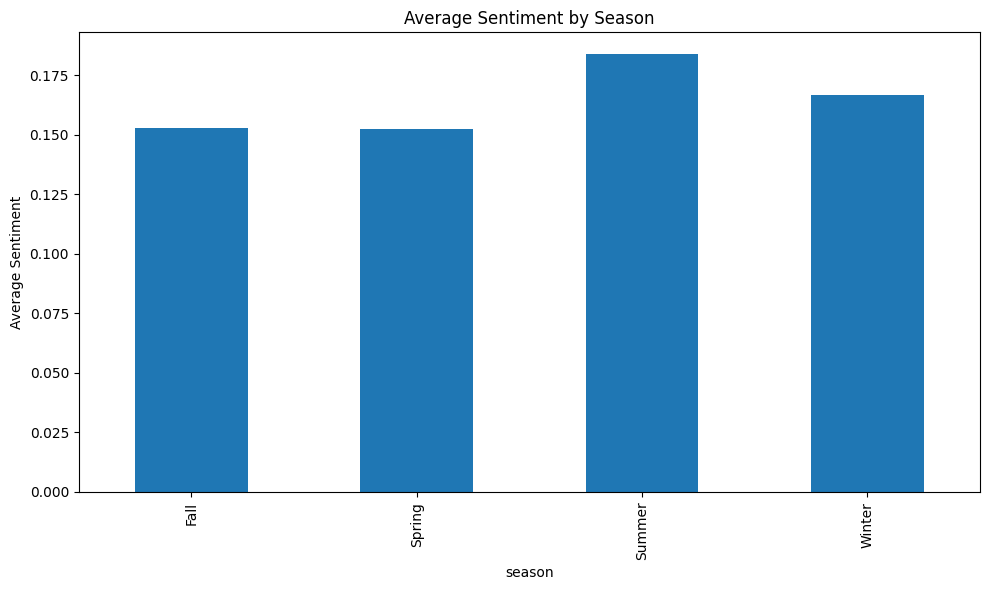

In [22]:
def analyze_seasonal_sentiment(reviews_df):
    # Add season column
    reviews_df['season'] = reviews_df['month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    
    # Calculate average sentiment by season
    seasonal_sentiment = reviews_df.groupby('season')['sentiment'].apply(
        lambda x: np.mean([s.polarity for s in x])
    )
    
    plt.figure(figsize=(10, 6))
    seasonal_sentiment.plot(kind='bar')
    plt.title('Average Sentiment by Season')
    plt.ylabel('Average Sentiment')
    plt.tight_layout()
    plt.show()

analyze_seasonal_sentiment(reviews_df)


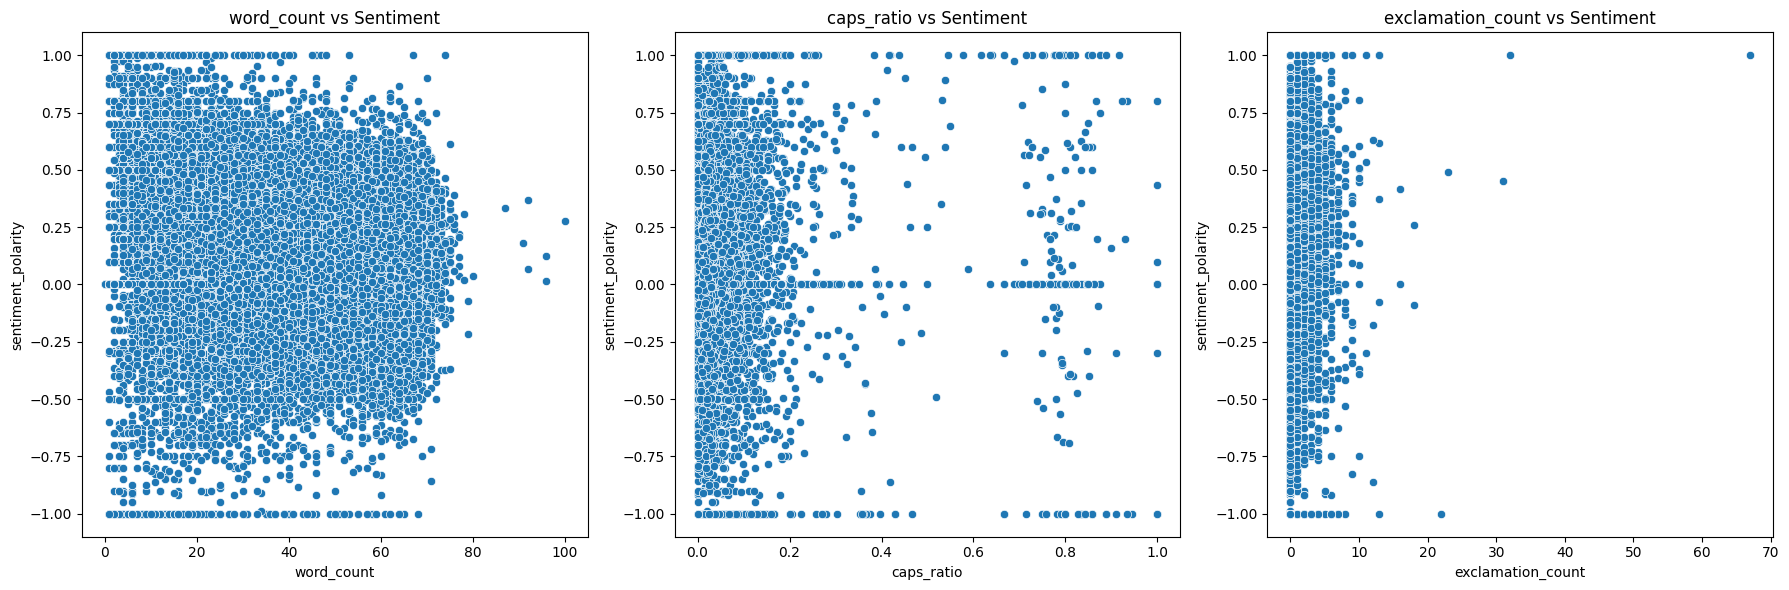

In [23]:
def analyze_text_features(reviews_df):
    # Add text analysis features
    reviews_df['word_count'] = reviews_df['comment'].str.split().str.len()
    reviews_df['caps_ratio'] = reviews_df['comment'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )
    reviews_df['exclamation_count'] = reviews_df['comment'].str.count('!')
    
    # Analyze relationship with sentiment
    features = ['word_count', 'caps_ratio', 'exclamation_count']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, feature in enumerate(features):
        sns.scatterplot(data=reviews_df, x=feature, 
                       y='sentiment_polarity', ax=axes[i])
        axes[i].set_title(f'{feature} vs Sentiment')
    
    plt.tight_layout()
    plt.show()

analyze_text_features(reviews_df)
